## Data Preprocessing

In [2]:
import os
from glob import glob
import numpy as np
import pandas as pd
from PIL import Image
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import torch.optim as optim

from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid


In [3]:
# data path that training set is located
path = "../data/fruits/fruits-360/"
# this joins the path + folder and each files e.g. '../data/fruits/fruits-360/Training/Apple Braeburn/115_100.jpg'
files_training = glob(os.path.join(path,'Training', '*/*.jpg'))
num_images = len(files_training)
print('Number of images in Training file:', num_images)

Number of images in Training file: 67692


In [4]:
# just to see how many images we have for each label, minimum one and average one, with nice printing style

min_images = 1000
im_cnt = []
class_names = []
print('{:18s}'.format('class'), end='')
print('Count:')
print('-' * 24)
for folder in os.listdir(os.path.join(path, 'Training')):
    folder_num = len(os.listdir(os.path.join(path,'Training',folder)))
    im_cnt.append(folder_num)
    class_names.append(folder)
    print('{:20s}'.format(folder), end=' ')
    print(folder_num)
        
num_classes = len(class_names)
print("\nMinumum images per category:", np.min(im_cnt), 'Category:', class_names[im_cnt.index(np.min(im_cnt))])    
print('Average number of Images per Category: {:.0f}'.format(np.array(im_cnt).mean()))
print('Total number of classes: {}'.format(num_classes))

class             Count:
------------------------
Apple Braeburn       492
Apple Crimson Snow   444
Apple Golden 1       480
Apple Golden 2       492
Apple Golden 3       481
Apple Granny Smith   492
Apple Pink Lady      456
Apple Red 1          492
Apple Red 2          492
Apple Red 3          429
Apple Red Delicious  490
Apple Red Yellow 1   492
Apple Red Yellow 2   672
Apricot              492
Avocado              427
Avocado ripe         491
Banana               490
Banana Lady Finger   450
Beetroot             450
Blueberry            462
Cactus fruit         490
Cantaloupe 1         492
Cantaloupe 2         492
Carambula            490
Cauliflower          702
Cherry 1             492
Cherry 2             738
Cherry Rainier       738
Cherry Wax Black     492
Cherry Wax Red       492
Cherry Wax Yellow    492
Chestnut             450
Clementine           490
Cocos                490
Corn                 450
Corn Husk            462
Cucumber Ripe 2      468
Dates                490


In [5]:
fruit_data = pd.DataFrame(data = im_cnt,index = class_names,columns=["image_number"])
fruit_data.head()

top_ten = fruit_data.sort_values(by="image_number",ascending=False)[:10]
bottom_ten = fruit_data.sort_values(by="image_number",ascending=True)[:10]

frames = [top_ten, bottom_ten]
merged_tens = pd.concat(frames)

from sklearn.utils import shuffle
merged_tens = shuffle(merged_tens)

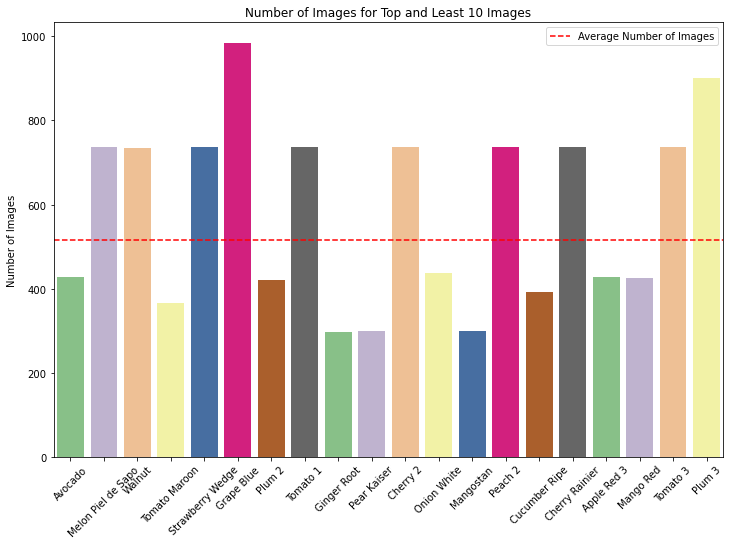

In [33]:
import seaborn as sns
plt.figure(figsize = (12,8))
chart = sns.barplot(x=merged_tens.index, y = merged_tens["image_number"],data=merged_tens, palette="Accent")
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
chart.set_ylabel("Number of Images")
plt.axhline(y=np.mean(im_cnt), color='r', linestyle='--',label = "Average Number of Images")
plt.legend()
plt.title("Number of Images for Top and Least 10 Images")
plt.savefig("../plots/number_of_images.png")
plt.show()

In [7]:
# Just to guess pop_mean and pop_std

tensor_transform = transforms.Compose([transforms.ToTensor()])

training_data = ImageFolder(os.path.join(path, 'Training'), tensor_transform)

data_loader = torch.utils.data.DataLoader(training_data, batch_size=512, shuffle=True)

In [8]:
%time
# this part takes a bit long
pop_mean = [0.6840367,0.5786325,0.5037564]  # normally it was --> []
pop_std = [0.30334985,0.3599262,0.3913685]

# for i, data in tqdm(enumerate(data_loader, 0)):
#     numpy_image = data[0].numpy()
    
#     batch_mean = np.mean(numpy_image, axis=(0,2,3))
#     batch_std = np.std(numpy_image, axis=(0,2,3))
    
#     pop_mean.append(batch_mean)
#     pop_std.append(batch_std)

# pop_mean = np.array(pop_mean).mean(axis=0)
# pop_std = np.array(pop_std).mean(axis=0)

# that is why I am inserting last values 

print(pop_mean)
print(pop_std)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs
[0.6840367, 0.5786325, 0.5037564]
[0.30334985, 0.3599262, 0.3913685]


In [9]:
np.random.seed(123)
shuffle = np.random.permutation(num_images)

In [10]:
# split validation images

split_val = int(num_images * 0.2)
print('Total number of images:', num_images)
print('Number images in validation set:',len(shuffle[:split_val]))
print('Number images in train set:',len(shuffle[split_val:]))

Total number of images: 67692
Number images in validation set: 13538
Number images in train set: 54154


In [11]:
class FruitTrainDataset(Dataset):
    def __init__(self, files, shuffle, split_val, class_names, transform=transforms.ToTensor()):
        self.shuffle = shuffle
        self.class_names = class_names
        self.split_val = split_val
        self.data = np.array([files[i] for i in shuffle[split_val:]])
        self.transform=transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img = Image.open(self.data[idx])
        name = self.data[idx].split('/')[-2]
        y = self.class_names.index(name)
        img = self.transform(img)
            
        return img, y

class FruitValidDataset(Dataset):
    def __init__(self, files, shuffle, split_val, class_names, transform=transforms.ToTensor()):
        self.shuffle = shuffle
        self.class_names = class_names
        self.split_val = split_val
        self.data = np.array([files[i] for i in shuffle[:split_val]])
        self.transform=transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img = Image.open(self.data[idx])
        name = self.data[idx].split('/')[-2]
        y = self.class_names.index(name)
        img = self.transform(img)
            
        return img, y
    
class FruitTestDataset(Dataset):
    def __init__(self, path, class_names, transform=transforms.ToTensor()):
        self.class_names = class_names
        self.data = np.array(glob(os.path.join(path, '*/*.jpg')))
        self.transform=transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img = Image.open(self.data[idx])
        name = self.data[idx].split('/')[-2]
        y = self.class_names.index(name)
        img = self.transform(img)
            
        return img, y

In [24]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(pop_mean, pop_std) # These were the mean and standard deviations that we calculated earlier.
    ]),
    'Test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(pop_mean, pop_std) # These were the mean and standard deviations that we calculated earlier.
    ]),
    'valid': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(pop_mean, pop_std) # These were the mean and standard deviations that we calculated earlier.
    ])
}

train_dataset = FruitTrainDataset(files_training, shuffle, split_val, class_names, data_transforms['train'])
valid_dataset = FruitValidDataset(files_training, shuffle, split_val, class_names, data_transforms['valid'])
test_dataset = FruitTestDataset("../data/fruits/fruits-360/Test", class_names, transform=data_transforms['Test'])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

In [25]:
dataloaders = {'train': train_loader,
              'valid': valid_loader,
              'Test': test_loader}
dataset_sizes = {
    'train': len(train_dataset),
    'valid': len(valid_dataset),
    'Test': len(test_dataset)
}

In [41]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = pop_std * inp + pop_mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize = (12,8))
    plt.axis('off')
    if title is not None:
        plt.title(title)
    
    plt.imshow(inp)
    plt.savefig("../plots/random_fruits2.png")

['Onion Red', 'Grape White 3', 'Tomato 3', 'Banana Red', 'Cucumber Ripe', 'Plum', 'Grapefruit Pink', 'Corn', 'Tomato Heart', 'Apple Golden 1', 'Mulberry', 'Raspberry', 'Banana Lady Finger', 'Kumquats', 'Apple Golden 2', 'Plum', 'Strawberry', 'Nut Forest', 'Strawberry Wedge', 'Plum 3', 'Cocos', 'Mangostan', 'Cucumber Ripe', 'Carambula', 'Cocos', 'Melon Piel de Sapo', 'Tomato 3', 'Tomato Yellow', 'Cherry Wax Black', 'Mandarine', 'Apple Braeburn', 'Tomato Cherry Red']


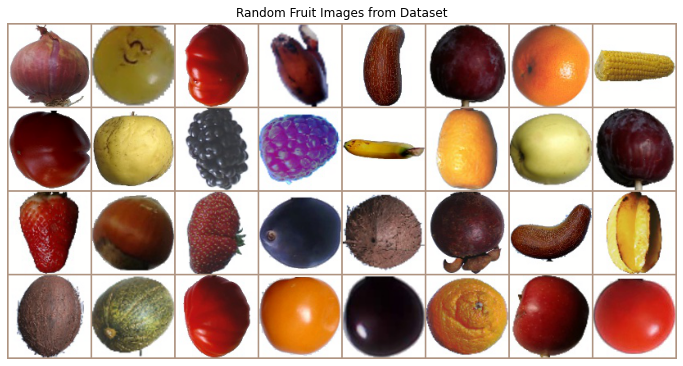

In [42]:
inputs, classes = next(iter(train_loader))
out = make_grid(inputs)

cats = ['' for x in range(len(classes))]
for i in range(len(classes)):
    cats[i] = class_names[classes[i].item()]
    
imshow(out,title="Random Fruit Images from Dataset")
print(cats)